# Setup

Sections of the notebook marked "Train" are used to train the model in the deployment pipeline.  All other cells will be excluded from the build of the model.

Train cells should include the binary saving out of the model (via joblib) as a "pickle" for reading in later

In [1]:
# Common imports
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# Assume a file data source
dataSource = 'File'

In [2]:
# Enable intelliense
%config IPCompleter.greedy=True

%matplotlib inline
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(train_labels, train_pred):
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot()

    labels = list(train_labels['Class'].value_counts().index)
    desc_labels = ['Legit', 'Fraud']
    #print(labels)

    confusion = confusion_matrix(train_labels, train_pred, labels=labels)
    ax.matshow(np.log(confusion + 1.001))

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))

    ax.set_xticklabels(desc_labels, rotation=90);
    ax.set_yticklabels(desc_labels);

    for i in range(len(labels)):
        for j in range(len(labels)):        
            ax.text(j, i, confusion[i,j], va='center', ha='center').set_backgroundcolor("white")

    plt.xlabel('Predicted')    
    plt.ylabel('Actual')
    
    return fig

# Select Input: "Kernel Restart & Run All" will block until the "Proceed" button is clicked after input selection.

In [3]:
# you need to 'pip3 install ipython_blocking' for blocking to work
import ipywidgets as widgets
from IPython.display import display
import ipython_blocking

selectw = widgets.RadioButtons(
    options=['File', 'Spark', 'VDB'],
    description='Select Input:',
    disabled=False
)

button = widgets.Button(description='Proceed',layout= widgets.Layout(border='1px solid black'))

box = widgets.VBox(children=[selectw, button], layout=widgets.Layout(border='solid', width='240px', height='160px'))
display(box)

<IPython.core.display.Javascript object>

# Use Magic to Block Until "Proceed" Button Clicked

In [6]:
%blockrun button
dataSource = selectw.value

# Read Data Based On Selection

In [7]:
if dataSource == 'Spark':
    print("Spark input not yet implemented. Switching to use: File")
    dataSource = 'File'

In [8]:
if dataSource == 'VDB':
    import jaydebeapi
    
    # The Vitual Database or VDB was created using Red Hat Data Virtualization.
    # The VDB provides a virtual view of credit card fraud data consolidated from 2 sources:
    # 1. MySQL (historical data from data warehouse)
    # 2. A CSV file (recent data)
    
    # set up VDB access
    # ****************** replace IP address with your VDB service cluster IP
    url = "jdbc:teiid:csvrdbmsdb.1@mm://172.30.126.110:31000"
    driver = "org.teiid.jdbc.TeiidDriver"
    user = "user"
    password = "mypassword"
    jarfile = "jdbc/teiid-9.0.6-jdbc.jar"
    conn = jaydebeapi.connect(driver, url, [user, password], jarfile)
    SQL_Query = "select * from CreditFraud"

    df = pd.read_sql_query(SQL_Query, conn)
    conn.close()

    # rename specific columns
    df.rename(columns={'Time_':'Time', 'Class_':'Class'}, inplace=True)
    
    print("Data loaded using VDB.")


In [9]:
if dataSource == 'File':

    print("Reading csv data")
    df = pd.read_csv ("data/creditcard.csv")
    # rename specific columns
    df.rename(columns={'Unnamed: 0':'Id'}, inplace=True)
    
    print("Data loaded using File.")


Reading csv data
Data loaded using File.


In [10]:
### Display some info about the data
print("Total number of credit card transaction rows: %d" % df.shape[0])

### Check the total number of rows with fraud detected
print("Total number of rows with fraud: %d" % df[(df['Class']==1)].shape[0])

### Rough check if data columns have consistent datatype (not Object)
print(df.dtypes)

Total number of credit card transaction rows: 10000
Total number of rows with fraud: 38
Id          int64
Time        int64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


# Train Sklearn Random Forest Model

In [11]:
# shuffle the rows
df = df.sample(frac=1).reset_index()

#Order the credit card transaction by transaction time
#df.sort_values(by=['Time'])

#number of rows in the dataset
n_samples = df.shape[0]
print("Samples: %d" % n_samples)

#Split into train and test
train_size = 0.75

train_limit = int(n_samples * train_size)
df_train = df.iloc[:train_limit]
df_test = df.iloc[train_limit:]


Samples: 10000


In [12]:
print('Training sample size: %d' % df_train.shape[0])
frauds_in_train_tx = df_train[df_train.Class == 1].shape[0]
print('Frauds transactions in training sample: %f' % (frauds_in_train_tx / train_limit))
print('Testing sample size: %d' % df_test.shape[0])
frauds_in_test_tx = df_test[df_test.Class == 1].shape[0]
print('Frauds transactions in testing sample: %f' % (frauds_in_test_tx / (n_samples - train_limit)))
      
#Define features and target variables for convenience.
drop_columns = ['Id', 'Time', 'Class']
select_column=['Class']

#Create Train Datasets
features_train = df_train.drop(drop_columns, axis=1)
target_train = df_train.loc[:, select_column]
#print("*Data Columns in features_train:")
#print(features_train.columns)
#print("*Data Columns in target_train:")
#print(target_train.columns)


#Create Test Datasets
features_test = df_test.drop(drop_columns, axis=1)
target_test = df_test.loc[:, select_column]

#Create a RondomForest Classifier mode
model = RandomForestClassifier(n_estimators=100, max_depth=4, n_jobs=10)

model.fit(features_train, target_train.values.ravel())

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

pred_train_prob = model.predict_proba(features_train)
pred_test_prob = model.predict_proba(features_test)

print("Number of features: %d" % len(model.feature_importances_))

Training sample size: 7500
Frauds transactions in training sample: 0.003733
Testing sample size: 2500
Frauds transactions in testing sample: 0.004000
Number of features: 30


# Plot the Confusion Matrix

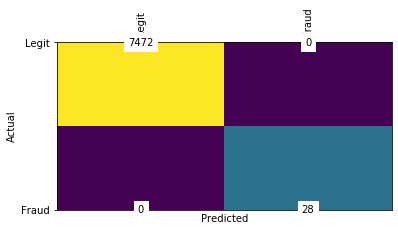

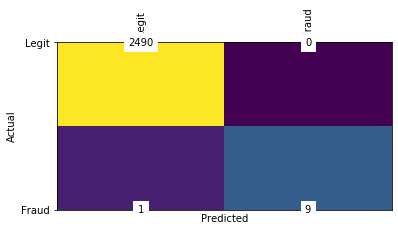

In [13]:
_=plot_confusion_matrix(target_train, model.predict(features_train))

_=plot_confusion_matrix(target_test, model.predict(features_test))

# Check the Important Features

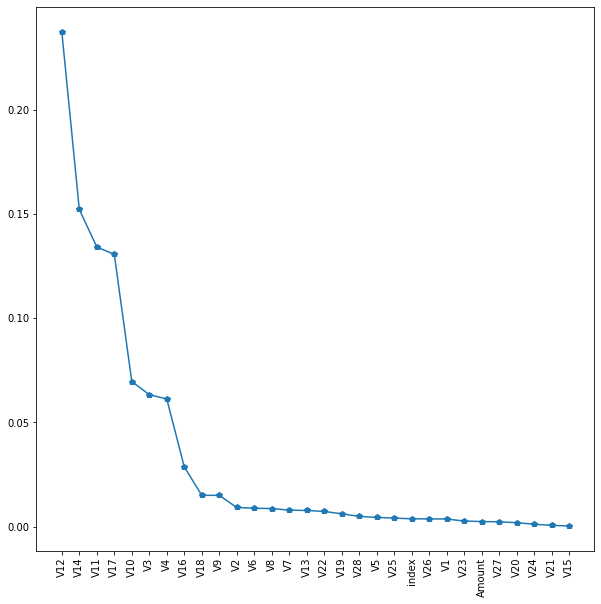

In [14]:
import operator

feat_imp = sorted(zip(features_train.columns, model.feature_importances_), key=operator.itemgetter(1), reverse=True)
X = [i[0] for i in feat_imp]
Y = [i[1] for i in feat_imp]
plt.figure(figsize=(10.,10.))

# plt.plot([i[0] for i in feat_imp], [i[1] for i in feat_imp], 'p-')
# sorts the X axis by the label name resulting in a weird-looking plot
plt.plot(Y, 'p-')
_ = plt.xticks(range(len(Y)), X, rotation=90)

##### Re-create the model with Important Features

# Alternatively, Perform a Correlation Analysis 
We will come to a similar conclusion on which features to include in the model: those with a low correlation coefficient should be excluded to avoid overfitting.
The graph has the features with the highest correlation coefficent plotted first. Class is to be excluded as it is the target for the correlation.
This shows the importance of data analysis.

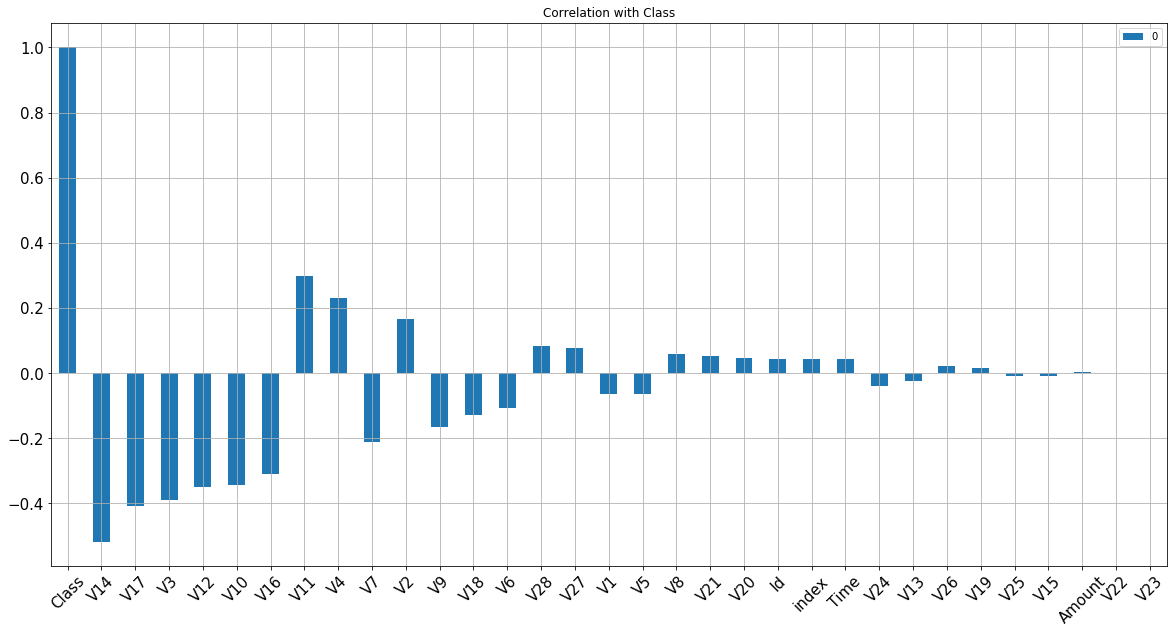

In [15]:
corr = df.loc[:, 'Class']

dfc = df.corrwith(corr).to_frame()
# use a temporary column to sort and then discard the column
dfc = (dfc.assign(A=abs(dfc))
    .sort_values(['A'],ascending=False)
    .drop('A', 1))
#print(dfc)
dfc.plot.bar(
        figsize = (20, 10), title = "Correlation with Class", fontsize = 15,
        rot = 45, grid = True)

# Re-create the model with Important Features

In [16]:
import joblib

#Define features and target variables.

# Choose either the features definition based on important features or correlation

## From the important features graph we only want seven important features:
##   V3,V4,V10,V11,V12,V14,V17
features = ['V3','V4','V10','V11','V12','V14','V17']

## using the correllation graph, select the top seven important features:
## V14,V17,V3,V12,V10,V16,V11
#features = ['V14','V17','V3','V12','V10','V16','V11']

non_features = [i for i in df_train.columns if i not in features]
class_column=['Class']


features_train = df_train.drop(non_features, axis=1)
target_train = df_train.loc[:, "Class"]

features_test = df_test.drop(non_features, axis=1)
target_test = df_test.loc[:, "Class"]
print("feature_test columns:")
print(features_test.columns)

model = RandomForestClassifier(n_estimators=200, max_depth=6, n_jobs=10, class_weight='balanced')

model.fit(features_train, target_train.values.ravel())

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

pred_train_prob = model.predict_proba(features_train)
pred_test_prob = model.predict_proba(features_test)

print("Number of features")
print(len(model.feature_importances_))
  
#save mode in filesystem
joblib.dump(model, 'model.pkl') 

feature_test columns:
Index(['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V17'], dtype='object')
Number of features
7


['model.pkl']

# Re-plot the Confusion Matrix

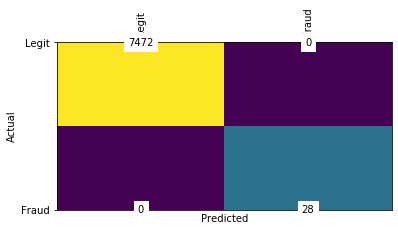

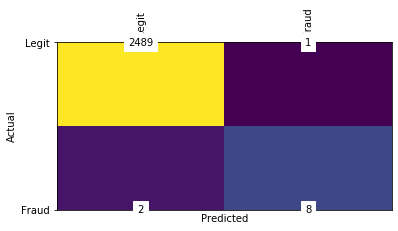

In [17]:
_ = plot_confusion_matrix(target_train.to_frame(), model.predict(features_train))

_ = plot_confusion_matrix(target_test.to_frame(), model.predict(features_test))

# Test the New Model

In [18]:
import time


fraudTest = df_test.loc[df_test['Class']== 1]
notFraudTest = df_test.loc[df_test['Class']== 0]

fraudTestFeatures = fraudTest.drop(columns=non_features)
notFraudTestFeatures = notFraudTest.drop(columns=non_features)

for index, row in fraudTestFeatures.iterrows():
    data = row
    rowdf = pd.DataFrame([data.tolist()], columns = features)
    print(model.predict(rowdf))
    time.sleep(2)


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[1]


# Seldon Deployment

This section will be extracted to represent the model being loaded in a format that is compatible with Seldon Core as outlined [in the documentation](https://docs.seldon.io/projects/seldon-core/en/v1.2.0/python/python_component.html)

In [19]:
import joblib

class Wrapper(object):

    def __init__(self):
        self.model = joblib.load('model.pkl')
        self.class_names = ['V3','V4','V10','V11','V12','V14','V17'];

    def predict(self,X,features_names):
        return self.model.predict_proba(X)